In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

def load_test_images():
    images = []
    
    test_images = glob.glob('test_images/*.jpg')
    
    for idx, fname in enumerate(test_images):
        img = cv2.imread(fname)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        images.append(img)
        
    problematic_images = glob.glob('problematic/*.jpg')
    
    for idx, fname in enumerate(problematic_images):
        img = cv2.imread(fname)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        images.append(img)
    
    return images

In [2]:
from skimage.feature import hog

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [3]:
def convert_color_space(image, target_color_space='RGB'):
        if target_color_space != 'RGB':
            if target_color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif target_color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif target_color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif target_color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif target_color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)
            
        return feature_image

In [4]:
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color2))

In [5]:
def color_hist(img, nbins=32, hrange=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=hrange)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=hrange)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=hrange)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [6]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [7]:
def extract_features(imgs, cspace='RGB', cspace_hog='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256),
                        orientation=9, pixels_per_cell=8, cell_per_block=2):
    # Create a list to append feature vectors to
    features = []
    
    for iname in imgs:
        img = cv2.imread(iname)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        img_converted = convert_color_space(img, cspace)
        img_converted_hog = convert_color_space(img, cspace)
        
        f_bin = bin_spatial(img_converted, spatial_size)
        f_hist = color_hist(img_converted, hist_bins, hist_range)
        f_hog_0 = get_hog_features(img_converted_hog[:,:,0], orientation, pixels_per_cell, cell_per_block, vis=False)
        f_hog_1 = get_hog_features(img_converted_hog[:,:,1], orientation, pixels_per_cell, cell_per_block, vis=False)
        f_hog_2 = get_hog_features(img_converted_hog[:,:,2], orientation, pixels_per_cell, cell_per_block, vis=False)
        
        features.append(np.concatenate((f_bin, f_hist, f_hog_0, f_hog_1, f_hog_2)))
    
    return features

In [8]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

In [9]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [10]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

Train classifier

In [85]:
# Parameters
ystart = 350
ystop = 700

orientation = 9
pixels_per_cell = 8
cell_per_block = 2
spatial_size = (32, 32)
hist_bins = 32
hist_range=(0, 256)
colorspace = 'YUV' # 'YCrCb', 'YUV'
colorspace_hog = 'YUV' # 'YCrCb', 'YUV'

In [86]:
import time

cars = glob.glob('vehicles/**/*.png', recursive=True)
non_cars = glob.glob('non-vehicles/**/*.png', recursive=True)

#TODO: remove this
#from random import shuffle
#shuffle(cars)
#shuffle(non_cars)
#sample_size = 1000
#cars = cars[0:sample_size]
#non_cars = non_cars[0:sample_size]
#TODO end

t0=time.time()
car_features = extract_features(cars, colorspace, colorspace_hog, spatial_size,
                        hist_bins, hist_range,
                        orientation, pixels_per_cell, cell_per_block)
t1=time.time()
non_car_features = extract_features(non_cars, colorspace, colorspace_hog, spatial_size,
                        hist_bins, hist_range,
                        orientation, pixels_per_cell, cell_per_block)
t2=time.time()
print(round(t2-t0, 2), 'Seconds to extract features...')

/Users/gierlickim/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


151.61 Seconds to extract features...


In [87]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = np.vstack((car_features, non_car_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

In [88]:
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV

parameters = {'C':[0.2, 0.5, 1.0, 3.0, 5.0, 8.0, 10.0]}
svc = LinearSVC()
clf = GridSearchCV(svc, parameters, n_jobs=4)
clf.fit(X_train, y_train)


GridSearchCV(cv=None, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'C': [0.2, 0.5, 1.0, 3.0, 5.0, 8.0, 10.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [89]:
clf.best_params_ 

{'C': 0.2}

In [90]:
clf.best_score_

0.9897240990990991

In [91]:
clf.cv_results_

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [92]:
from sklearn.svm import LinearSVC

# Use a linear SVC 
svc = LinearSVC(C=1.0) #LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

15.68 Seconds to train SVC...


In [93]:
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Test Accuracy of SVC =  0.9938


In [94]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cspace, cspace_hog):
    
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color_space(img_tosearch, cspace)
    ctrans_tosearch_hog = convert_color_space(img_tosearch, cspace_hog)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        ctrans_tosearch_hog = cv2.resize(ctrans_tosearch_hog, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch_hog[:,:,0]
    ch2 = ctrans_tosearch_hog[:,:,1]
    ch3 = ctrans_tosearch_hog[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bboxes = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, hist_bins, hist_range)

            np.concatenate((spatial_features ,hist_features, hog_feat1, hog_feat2, hog_feat3))
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bboxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img, bboxes

In [95]:
from scipy.ndimage.measurements import label

def process_image(img):
    
    img_converted = convert_color_space(img, 'HSV')
    
    channel = 2
    
    #features, hog_image = get_hog_features(img_converted[:,:,channel], orient=9, pix_per_cell=8, cell_per_block=2, vis=True)
    
    bboxes = []
    
    result_1, bboxes_1 = find_cars(img, ystart, ystop, 0.5, svc, X_scaler, orientation, pixels_per_cell, cell_per_block, spatial_size, hist_bins, colorspace, colorspace_hog)
    result_2, bboxes_2 = find_cars(img, ystart, ystop, 0.75, svc, X_scaler, orientation, pixels_per_cell, cell_per_block, spatial_size, hist_bins, colorspace, colorspace_hog)
    result_3, bboxes_3 = find_cars(img, ystart, ystop, 1.0, svc, X_scaler, orientation, pixels_per_cell, cell_per_block, spatial_size, hist_bins, colorspace, colorspace_hog)
    result_4, bboxes_4 = find_cars(img, ystart, ystop, 1.5, svc, X_scaler, orientation, pixels_per_cell, cell_per_block, spatial_size, hist_bins, colorspace, colorspace_hog)
    result_5, bboxes_5 = find_cars(img, ystart, ystop, 2.0, svc, X_scaler, orientation, pixels_per_cell, cell_per_block, spatial_size, hist_bins, colorspace, colorspace_hog)
    
    bboxes = bboxes + bboxes_1 + bboxes_2 + bboxes_3 + bboxes_4 + bboxes_5
    
    #binary_output = np.zeros_like(hog_image)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    #binary_output[(hog_image > 1.0)] = 1
    
    #result = hog_image
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, bboxes)
    heat = apply_threshold(heat, 2)
    heatmap = np.clip(heat, 0, 255)
    
    labels = label(heatmap)
    result = draw_labeled_bboxes(np.copy(img), labels)
    
    return result

In [96]:
images = load_test_images()

/Users/gierlickim/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


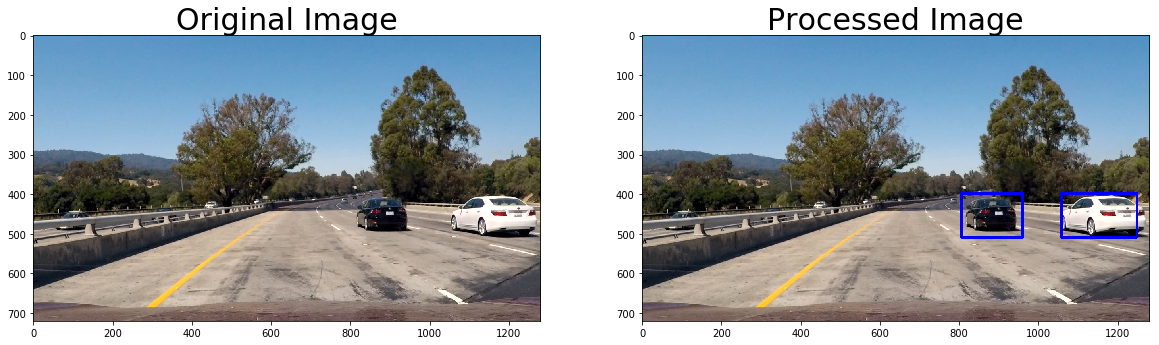

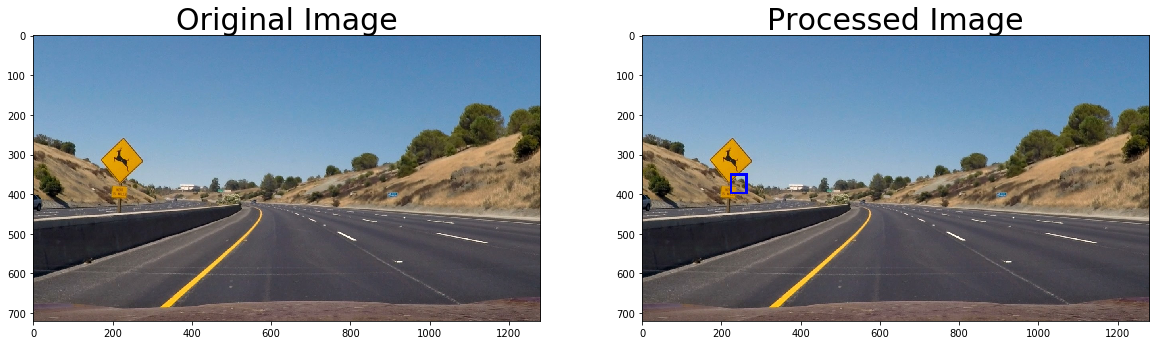

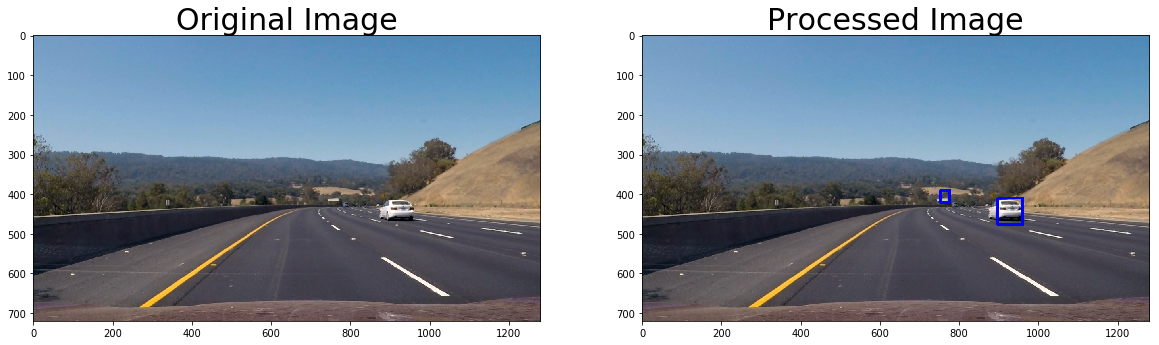

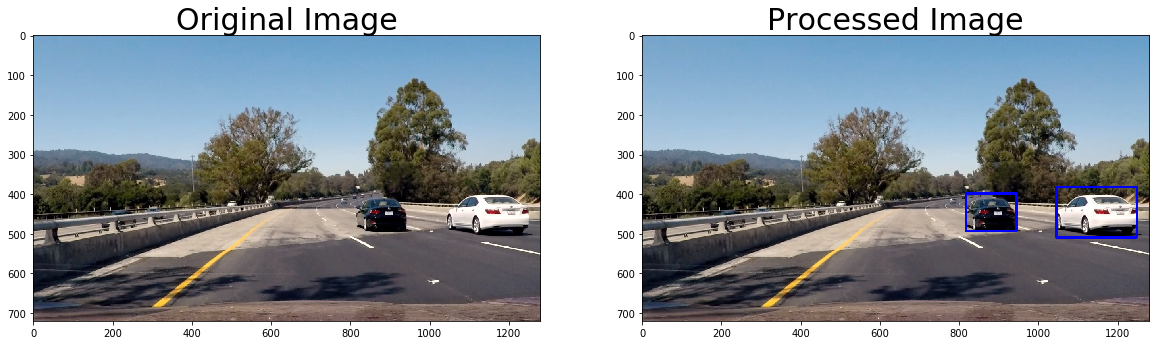

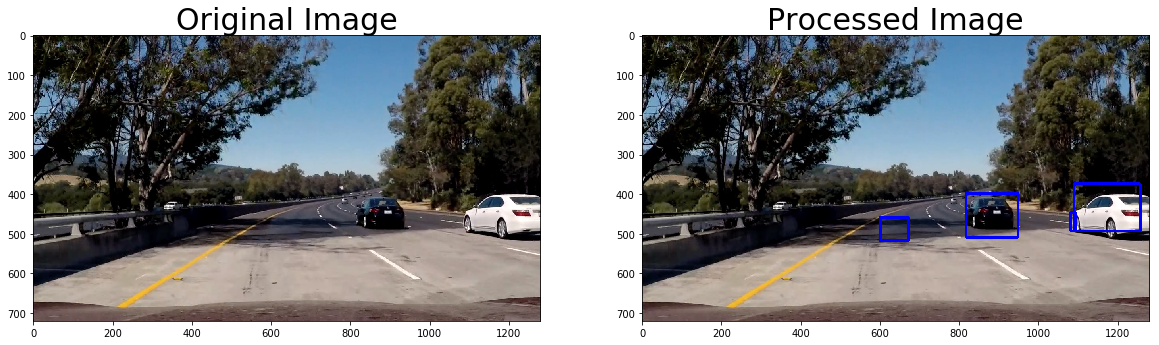

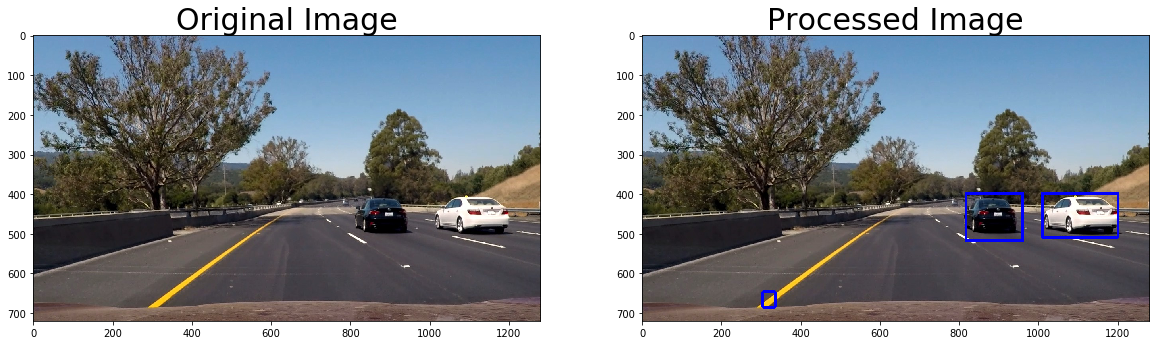

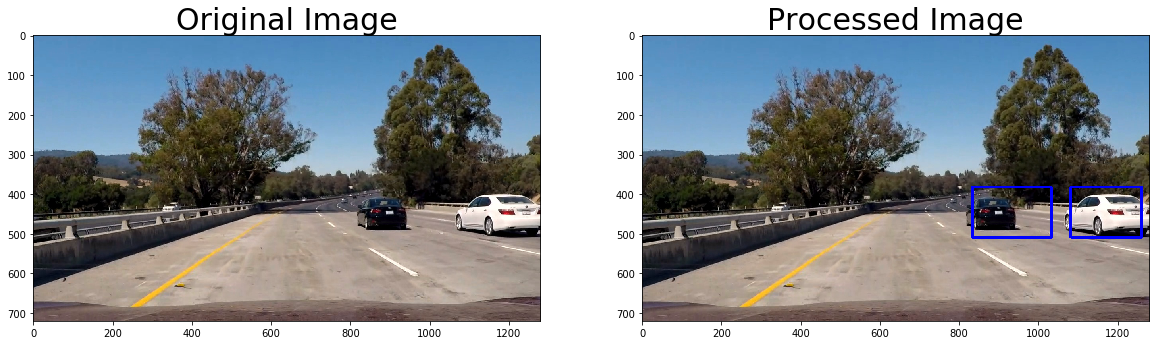

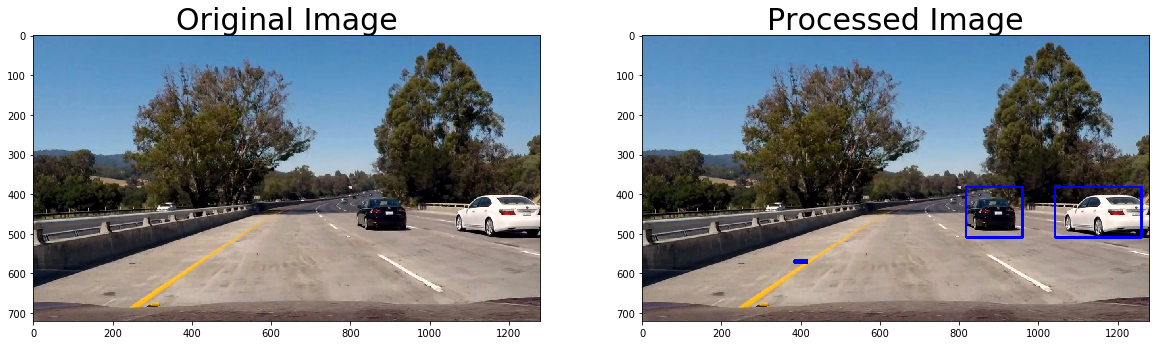

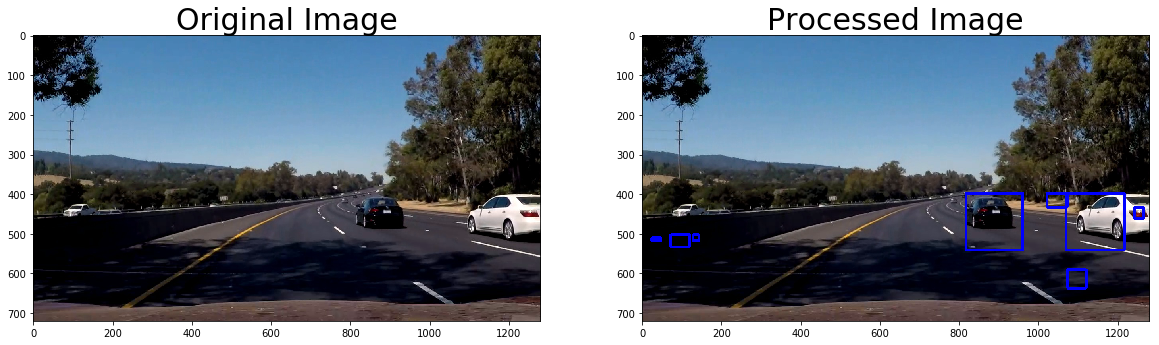

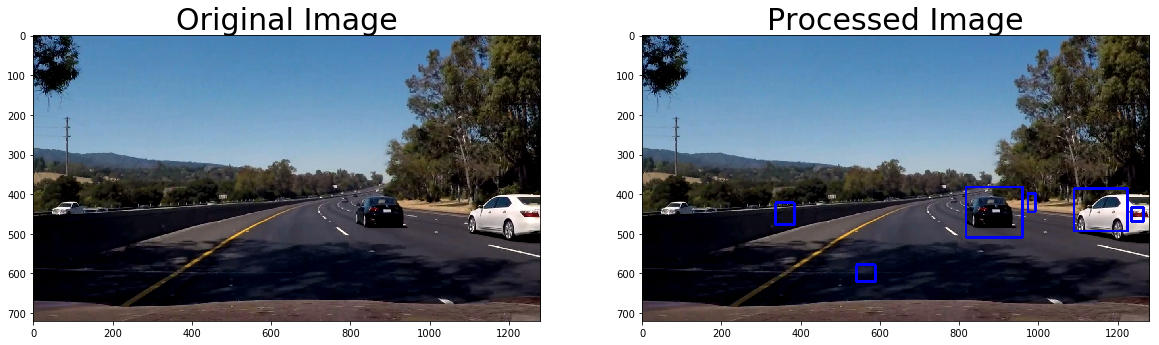

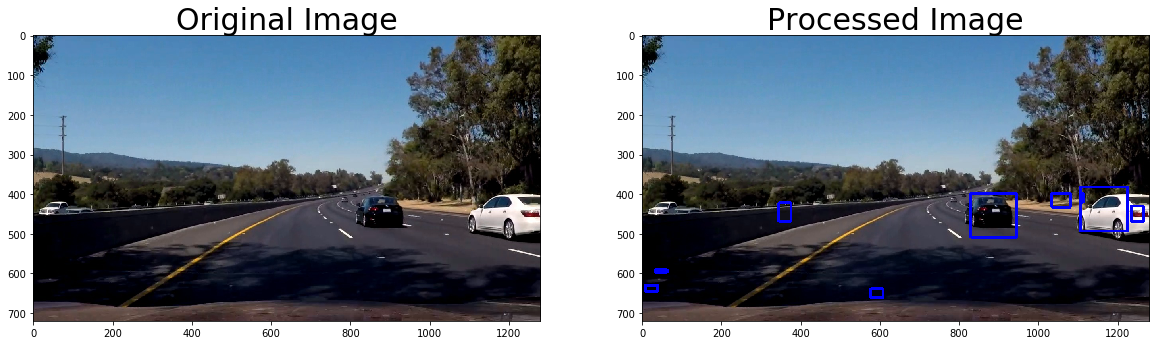

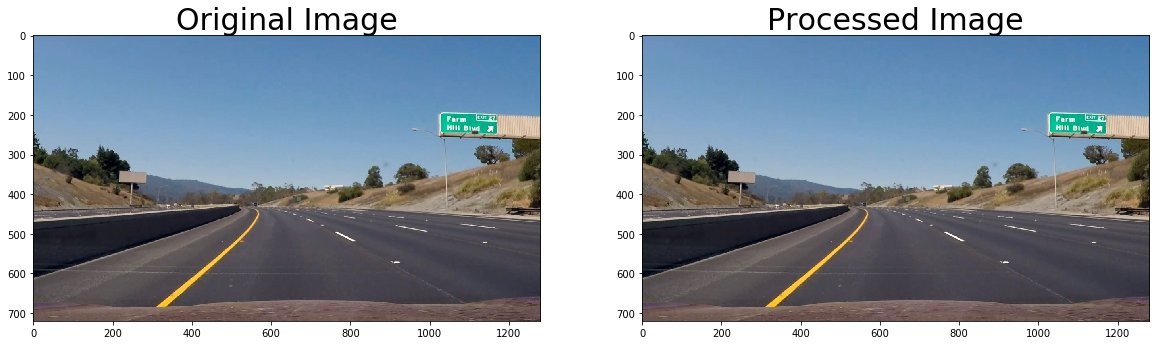

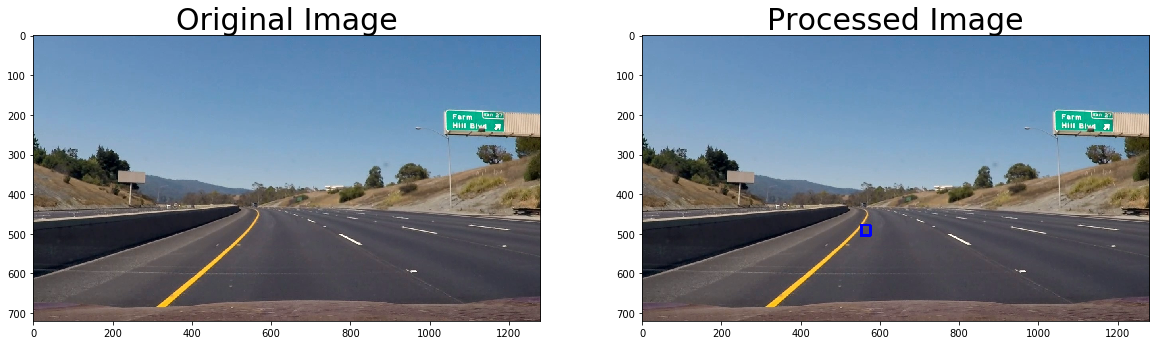

In [ ]:
import matplotlib.pyplot as plt

for img in images:
    processed = process_image(img)
    
    # Visualize                      
    %matplotlib inline
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(processed, cmap='gray')
    ax2.set_title('Processed Image', fontsize=30)
    plt.show()
    


In [35]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [41]:
output = 'project_video_processed.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,15)
clip1 = VideoFileClip("project_video.mp4").subclip(29,31)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_processed.mp4
[MoviePy] Writing video project_video_processed.mp4


 98%|█████████▊| 50/51 [09:18<00:09,  9.65s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_processed.mp4 

CPU times: user 9min 1s, sys: 6.28 s, total: 9min 7s
Wall time: 9min 20s


In [81]:
def play_with_parameters(orient, pix, cells):
    
    cspace = 'HSV'
    
    img_car = cv2.imread(cars[1])
    img_car = cv2.cvtColor(img_car, cv2.COLOR_BGR2RGB)
    img_car_converted = convert_color_space(img_car, cspace)
    img_non_car = cv2.imread('problematic/non_car.png')
    img_non_car = cv2.cvtColor(img_non_car, cv2.COLOR_BGR2RGB)
    img_non_car_converted = convert_color_space(img_non_car, cspace)
    
    f_hog_car_0, img_hog_car_0 = get_hog_features(img_car_converted[:,:,0], orient, pix, cells, vis=True)
    f_hog_car_1, img_hog_car_1 = get_hog_features(img_car_converted[:,:,1], orient, pix, cells, vis=True)
    f_hog_car_2, img_hog_car_2 = get_hog_features(img_car_converted[:,:,2], orient, pix, cells, vis=True)

    f_hog_non_car_0, img_hog_non_car_0 = get_hog_features(img_non_car_converted[:,:,0], orient, pix, cells, vis=True)
    f_hog_non_car_1, img_hog_non_car_1 = get_hog_features(img_non_car_converted[:,:,1], orient, pix, cells, vis=True)
    f_hog_non_car_2, img_hog_non_car_2 = get_hog_features(img_non_car_converted[:,:,2], orient, pix, cells, vis=True)

    
    # Visualize                      
    %matplotlib inline
    f, (ax1, ax2, ax3) = plt.subplots(3, 4, figsize=(30,20))
    ax1[0].imshow(img_car_converted[:,:,0], cmap='gray')
    ax1[0].set_title('Car Ch 1', fontsize=30)
    ax1[1].imshow(img_hog_car_0)
    ax1[1].set_title('HOG Car Ch 1', fontsize=30)
    ax1[2].imshow(img_non_car_converted[:,:,0], cmap='gray')
    ax1[2].set_title('Non-car Ch 1', fontsize=30)
    ax1[3].imshow(img_hog_non_car_0)
    ax1[3].set_title('HOG Non-car Ch 1', fontsize=30)
    
    ax2[0].imshow(img_car_converted[:,:,1], cmap='gray')
    ax2[0].set_title('Car Ch 2', fontsize=30)
    ax2[1].imshow(img_hog_car_1)
    ax2[1].set_title('HOG Car Ch 2', fontsize=30)
    ax2[2].imshow(img_non_car_converted[:,:,1], cmap='gray')
    ax2[2].set_title('Non-car Ch 2', fontsize=30)
    ax2[3].imshow(img_hog_non_car_1)
    ax2[3].set_title('HOG Non-car Ch 2', fontsize=30)
    
    ax3[0].imshow(img_car_converted[:,:,2], cmap='gray')
    ax3[0].set_title('Car Ch 3', fontsize=30)
    ax3[1].imshow(img_hog_car_2)
    ax3[1].set_title('HOG Car Ch 3', fontsize=30)
    ax3[2].imshow(img_non_car_converted[:,:,2], cmap='gray')
    ax3[2].set_title('Non-car Ch 3', fontsize=30)
    ax3[3].imshow(img_hog_non_car_2)
    ax3[3].set_title('HOG Non-car Ch 3', fontsize=30)

    plt.show()

/Users/marcin/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


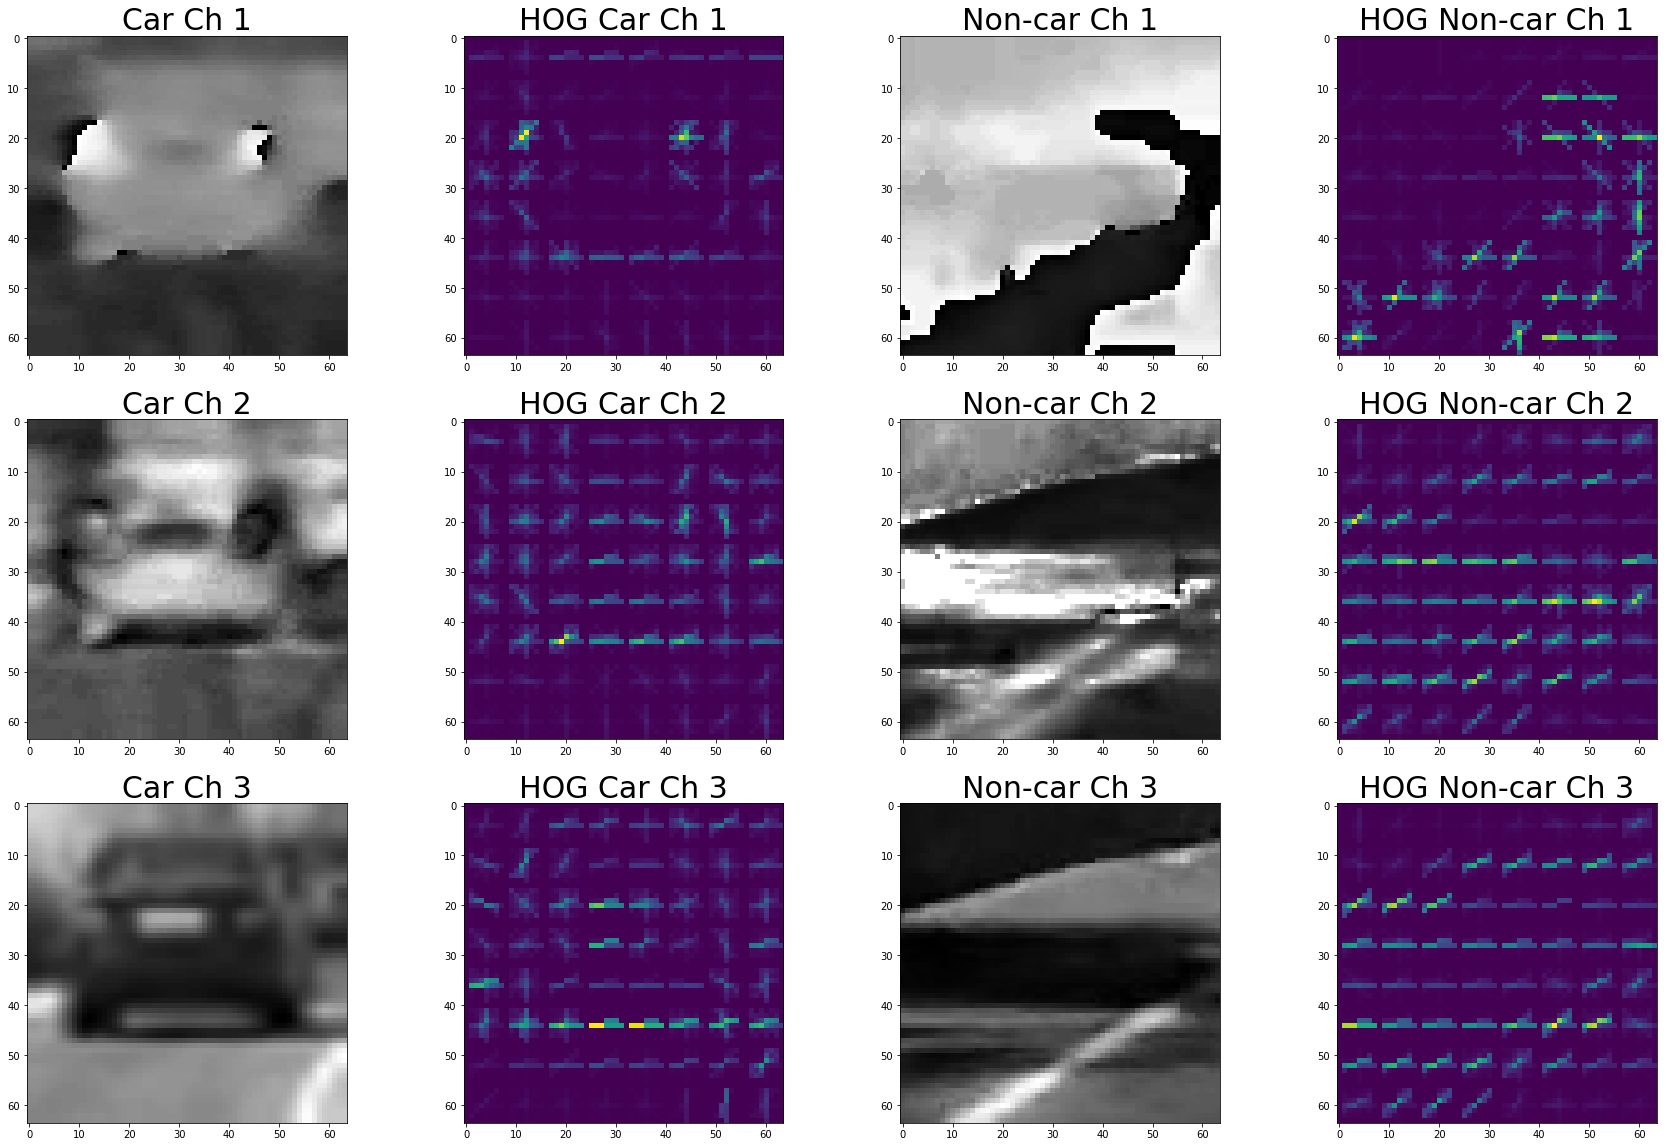

In [60]:
play_with_parameters(12, 8, 2)

In [29]:
from IPython.html import widgets
from IPython.html.widgets import interact
from IPython.display import display

/Users/marcin/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


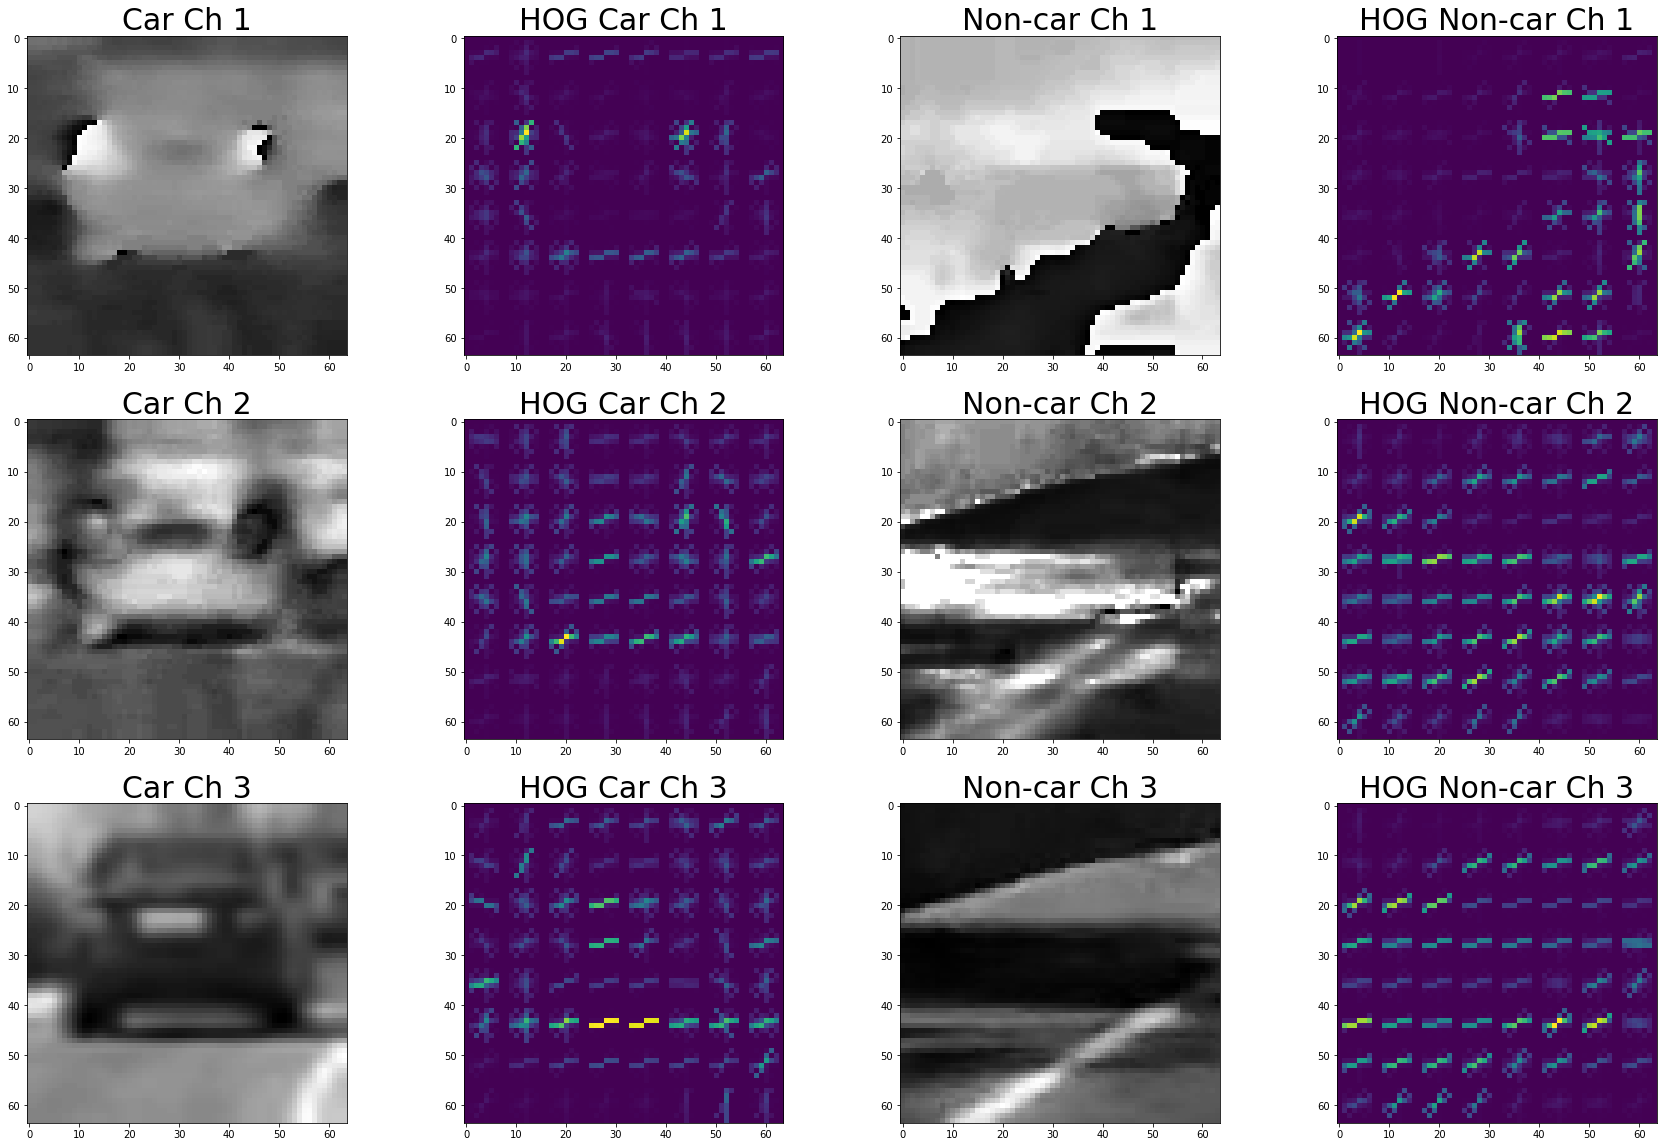

In [30]:
interact(play_with_parameters, orient=(6,24), pix=(2,16), cells=(1,8))